# Problem Statement
## Forcasting covid 19 cases in India

PTID-CDS-DEC-23-1722

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read CSV file for condirmed cases
rd1=pd.read_csv('time_series_covid19_confirmed_global.csv')
rd1

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,29906,30574,31362,32250,33006,33843,34401,35003,35686,36151
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2009,2011,2013,2016,2019,2022,2024,2026,2026,2028
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,13466,13539,13720,13819,13887,13928,14022,14070,14131,14175


In [3]:
rd=rd1[143:144].T #Find the col corresponding to India and transpose it 
rd=rd[4:]
rd=rd.reset_index()
rd=rd.rename(columns={"index":"Date",143:'Cases'})

In [4]:
#Convert data into standard timeseries format
rd['Date']=pd.to_datetime(rd['Date'], format="%m/%d/%y")
rd['Cases']=rd['Cases'].astype('int')
rd.index=rd['Date']
del rd['Date']

In [5]:
rd.head()
rd.info()

,Cases
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2020-01-22 to 2020-09-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Cases   244 non-null    int32
dtypes: int32(1)
memory usage: 2.9 KB


## Exploratory Data Analysis

<Axes: xlabel='Date'>

Text(0, 0.5, 'Number of Covid 19 cases')

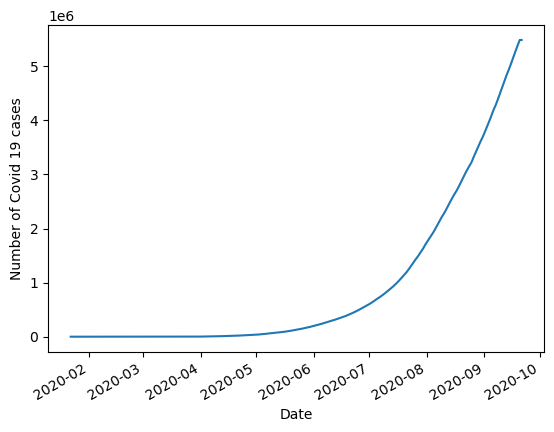

In [6]:
rd.plot(x_compat=True,legend=None)
plt.ylabel('Number of Covid 19 cases')

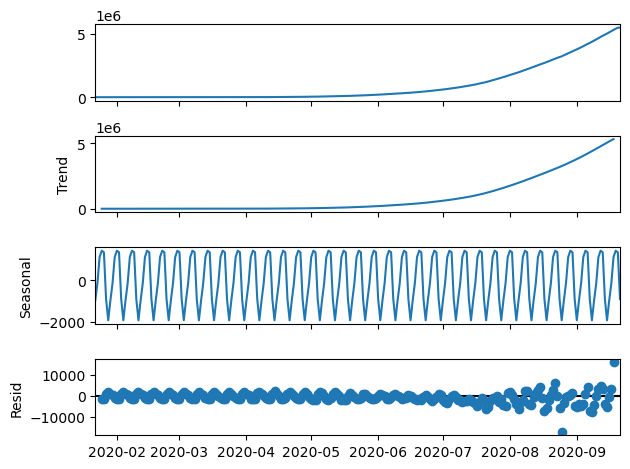

In [7]:
seasonal_decompose(rd,model='additive').plot();
#Seasonal decomposition plot showing trend, seasonality and residue

### Autocorrelation function

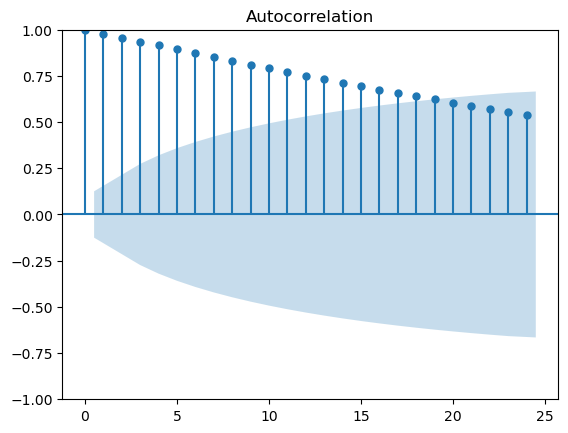

In [8]:
# plotting the autocorrelation function
plot_acf(rd);

###  Partial autocorrelation function

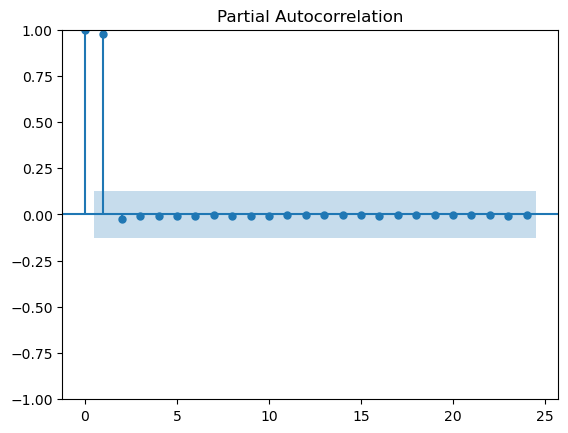

In [9]:
plot_pacf(rd);

### Stationarity

In [10]:
#Running the adfuller test to check for stationarity
adfuller(rd)[1]

0.16977456577420308

p value 0.169 > 0.05, Therefore series is not stationary. 

In [11]:
#Let's look at it's first difference. 
adfuller(rd.diff(1).dropna())[1]

0.000638737062080407

p value 0.0006 < 0.05, Therefore data integrated to order 1 is stationary. 


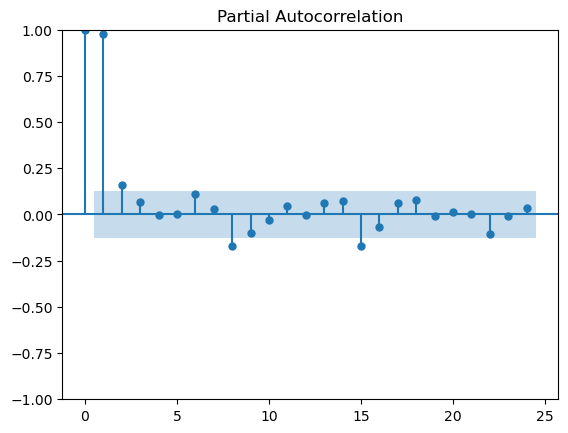

In [12]:
plot_pacf(rd.diff(1).dropna());
#PACF of 1st integration showing stationarity

## Model Building

In [13]:
#Now that we have a stationary series, we can start forcasting
s=int(0.8*len(rd))
train,test=rd.diff(1).dropna()[:s],rd.diff(1).dropna()[s:-1]
#Partioning training and testing data, 80:20 train test split

### Autoregressive model

In [14]:
ar_select_order(rd.diff(1).dropna(),maxlag=13,glob=True).ar_lags
#calculate autoregression lags

[1, 3, 6, 7, 9, 10, 12]

In [15]:
model=AutoReg(train,lags=[1, 3, 6, 7, 9, 10, 12])
pred=model.fit().predict(start=s,end=len(rd)-3)

### Metrics for model

In [16]:
# Mean squared error
mse(test.values.flatten(),pred)

40021290.71513707

In [17]:
# Root Mean Square Error
rmse(test.values.flatten(),pred)

6326.238275242015

In [18]:
# Root Mean Squared Percentage Error
rmspe(test.values.flatten(),pred)

0.7648163009312254

In [19]:
# Mean absolute percentage erro
mape(test,pred)

0.06217036260585533

Text(0.5, 1.0, 'Training, Testing and, Forecasting data')

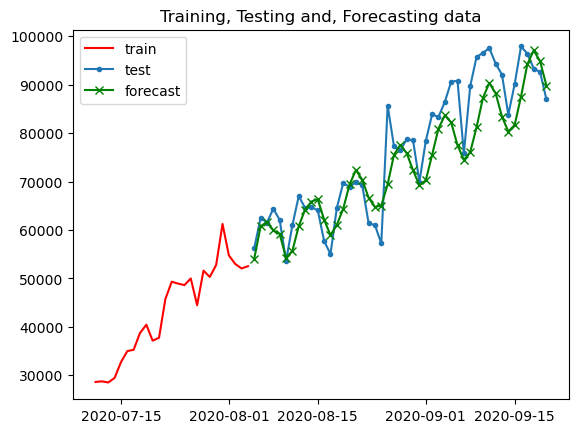

In [20]:
#Ploting the forecast
plt.plot(train[int(0.7*len(rd)):],color='red',label='train')
plt.plot(test,label='test',marker='.')
plt.plot(pred,color='green',label='forecast',marker='x')
plt.legend(['train','test', 'forecast'], loc ="best") 
plt.title("Training, Testing and, Forecasting data")

#### Result
| Metric | Value | 
|:--------:|:--------:|
|  Mean absolute percentage error (MAPE)   | 6.21%   | 
|  Root Mean Squared Percentage Error (RMPSE)  | 0.76%   | 

Since $MAPE < 10\%$, this model constitutes highly accurate forecasting. 


### ARIMA model

#### Paramter Tuning

In [21]:
#Arima models have (p,d,q) where p is the order of autoregressive model, d is the degree of differencing,
#and q is the order of moving-average model
#We use aic to calculate the optimum value of pdq
pdq=list(product(range(0,5),range(0,5),range(0,5)))
list1=[]
list2=[]
for params in pdq: #iterating params over pdq
        model = ARIMA(train, order=params)#training model on various pdq values
        list1.append(params)
        list2.append(model.fit().aic)
list1[list2.index(min(list2))]

(4, 2, 4)

Text(0.5, 1.0, 'Training data, Test, Forecast')

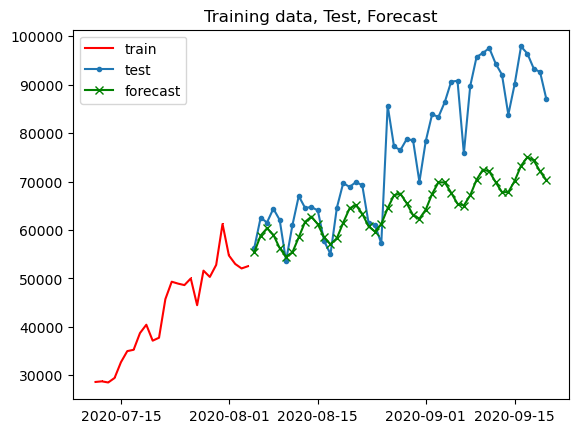

In [22]:
model = ARIMA(train, order=(4, 2, 4));
pred=model.fit().forecast(steps=len(test))
plt.plot(train[int(0.7*len(rd)):],color='red',label='train',marker=',')
plt.plot(test,label='test',marker='.')
plt.plot(pred,color='green',label='forecast',marker='x')
plt.legend(['train','test', 'forecast'], loc ="best") 
plt.title("Training data, Test, Forecast")

### Metrics for the model

In [23]:
# Mean squared error
mse(test.values.flatten(),pred)

214465709.12847924

In [24]:
# Root Mean Square Error
rmse(test.values.flatten(),pred)

14644.647798034586

In [25]:
# Root Mean Squared Percentage Error
rmspe(test.values.flatten(),pred)

1.6565087678221215

In [26]:
# Mean absolute percentage erro
mape(test,pred)

0.14125958950283826

#### Results
| Metric | Value | 
|:--------:|:--------:|
|  Mean absolute percentage error (MAPE)   | 14.12%   | 
|  Root Mean Squared Percentage Error (RMPSE)  | 1.65%   | 

Since $10\% ≤ MAPE <20\%$, this model constitutes good forecasting. 

# Conclusion
### After running different models for forecasting the following insights have been drawn from the dataset-
 * The MAPE of the AR model is more accurate than the ARIMA model. 
 * The MAPE of the AR model is 6.21% while the MAPE of ARIMA model is 14.12%.
 * So, the AR model should be considered for forecasting purposes.

## Recommendations to the Health Department of Government-

* The Covid forecast data can be very helpful to the local and national health departments, so the government should consider sharing this data with the local authorities.
* During a predicted downturn, the government should take the chance to stock up on medical supplies to provide appropriate medical services to every individual affected by the virus.
* During a predicted upturn,first and foremost the government should use every resource it has under it's wings and try to control the situation as soon as possible, so as to stop the virus from spreading quickly and treat those who have been infected using the stock-piled supplies procured during the downturn.
* The virus cannot be stopped by the government alone, public cooperation is essential.
* Government should spread awareness among the people and educate them on how to save themselves from the virus.